# EDA & Feature Pipeline (Autoscaling v2)

In [4]:
#!pip install -q pyspark gdown

In [5]:
# PySpark imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, lit, when, regexp_extract, to_timestamp,
    year, month, dayofmonth, hour, minute, dayofweek,
    length, window, count, sum as spark_sum,
    avg as spark_avg, round as spark_round,
    min as spark_min, max as spark_max,
    stddev as spark_stddev, lag, desc,
    row_number, to_utc_timestamp
)
from pyspark.sql.window import Window

# Analysis imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
import warnings
import os
import glob
import shutil
import gdown

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [6]:
# Download data files
train_id = "1-c20gJwbzjLsUWFFKbC1OOKxUb17MHSk"
test_id = "1PaS5kJruNOy8OY6BZD_Ze5r3Y0Gowfse"

gdown.download(f"https://drive.google.com/uc?id={train_id}", "train.txt", quiet=False)
gdown.download(f"https://drive.google.com/uc?id={test_id}", "test.txt", quiet=False)

print("✅ Downloaded train.txt and test.txt")

Downloading...
From (original): https://drive.google.com/uc?id=1-c20gJwbzjLsUWFFKbC1OOKxUb17MHSk
From (redirected): https://drive.google.com/uc?id=1-c20gJwbzjLsUWFFKbC1OOKxUb17MHSk&confirm=t&uuid=359b2687-e377-4a6b-8e55-72f4f712e888
To: /Users/maydothi/Documents/dataflow/igt/dataFlow-2026-/train.txt
100%|██████████| 320M/320M [00:35<00:00, 9.10MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PaS5kJruNOy8OY6BZD_Ze5r3Y0Gowfse
To: /Users/maydothi/Documents/dataflow/igt/dataFlow-2026-/test.txt
100%|██████████| 56.8M/56.8M [00:06<00:00, 8.73MB/s]

✅ Downloaded train.txt and test.txt


In [7]:
# Initialize Spark
spark = SparkSession.builder \
    .appName("NASA Log EDA - Decomposition") \
    .getOrCreate()

print("✅ Spark session initialized")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/31 01:03:19 WARN Utils: Your hostname, MacBook-Air-cua-o-3.local, resolves to a loopback address: 127.0.0.1; using 192.168.88.103 instead (on interface en0)
26/01/31 01:03:19 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/31 01:03:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


✅ Spark session initialized


In [8]:
# Read raw logs
train_df = spark.read.text("train.txt") \
    .withColumnRenamed("value", "raw_log") \
    .withColumn("split", lit("train"))

test_df = spark.read.text("test.txt") \
    .withColumnRenamed("value", "raw_log") \
    .withColumn("split", lit("test"))

print(f"Train raw count: {train_df.count():,}")
print(f"Test raw count:  {test_df.count():,}")

Train raw count: 2,934,961
Test raw count:  526,651


### Nạp dữ liệu thô (train/test 1m/5m/15m) qua Spark → pandas

In [9]:
# Regex pattern for Apache Common Log Format
log_pattern = r'^(\S+) \S+ \S+ \[(.*?)\] "(\S+) (\S+) (\S+)" (\d{3}) (\d+|-)'

def parse_and_normalize_logs(df):
    """Parse Apache logs and normalize into structured columns"""
    parsed_df = df.select(
        regexp_extract(col("raw_log"), log_pattern, 1).alias("host"),
        regexp_extract(col("raw_log"), log_pattern, 2).alias("timestamp_str"),
        regexp_extract(col("raw_log"), log_pattern, 3).alias("method"),
        regexp_extract(col("raw_log"), log_pattern, 4).alias("url"),
        regexp_extract(col("raw_log"), log_pattern, 5).alias("protocol"),
        regexp_extract(col("raw_log"), log_pattern, 6).alias("status_code_str"),
        regexp_extract(col("raw_log"), log_pattern, 7).alias("bytes_str"),
        col("split")
    )
    
    # Filter malformed logs
    parsed_df = parsed_df.filter(length(col("timestamp_str")) > 0)
    
    # Convert timestamp
    parsed_df = parsed_df.withColumn(
        "timestamp",
        to_utc_timestamp(
            to_timestamp(col("timestamp_str"), "dd/MMM/yyyy:HH:mm:ss Z"),
            "UTC"
        )
    )
    
    # Filter NULL timestamps
    parsed_df = parsed_df.filter(col("timestamp").isNotNull())
    
    # Cast types
    parsed_df = parsed_df.withColumn(
        "status_code",
        when(col("status_code_str") == "-", None)
        .otherwise(col("status_code_str").cast("int"))
    )
    
    parsed_df = parsed_df.withColumn(
        "bytes",
        when(col("bytes_str") == "-", 0)
        .otherwise(col("bytes_str").cast("long"))
    )
    
    # Select final columns
    final_df = parsed_df.select(
        "host", "timestamp", "method", "url", "protocol",
        "status_code", "bytes", "split"
    )
    
    return final_df

# Parse both datasets
train_df_parsed = parse_and_normalize_logs(train_df)
test_df_parsed = parse_and_normalize_logs(test_df)

print(f"Train parsed: {train_df_parsed.count():,}")
print(f"Test parsed:  {test_df_parsed.count():,}")

print("\n=== SAMPLE PARSED DATA ===")
train_df_parsed.show(5, truncate=50)

Train parsed: 2,928,199
Test parsed:  525,100

=== SAMPLE PARSED DATA ===
+--------------------+-------------------+------+-----------------------------------------------+--------+-----------+-----+-----+
|                host|          timestamp|method|                                            url|protocol|status_code|bytes|split|
+--------------------+-------------------+------+-----------------------------------------------+--------+-----------+-----+-----+
|        199.72.81.55|1995-07-01 11:00:01|   GET|                               /history/apollo/|HTTP/1.0|        200| 6245|train|
|unicomp6.unicomp.net|1995-07-01 11:00:06|   GET|                            /shuttle/countdown/|HTTP/1.0|        200| 3985|train|
|      199.120.110.21|1995-07-01 11:00:09|   GET|   /shuttle/missions/sts-73/mission-sts-73.html|HTTP/1.0|        200| 4085|train|
|  burger.letters.com|1995-07-01 11:00:11|   GET|                /shuttle/countdown/liftoff.html|HTTP/1.0|        304|    0|train|
|      19

### Thiết lập cửa sổ thời gian và phân tách train/test theo timestamp

In [10]:
# Combine train and test
combined_df = train_df_parsed.unionByName(test_df_parsed)

print("=== BASIC STATISTICS ===")
print(f"Total records: {combined_df.count():,}")

print("\n=== TIME RANGE ===")
combined_df.agg(
    spark_min("timestamp").alias("min_ts"),
    spark_max("timestamp").alias("max_ts")
).show(truncate=False)

print("=== TOP STATUS CODES ===")
combined_df.groupBy("status_code").count().orderBy(desc("count")).show(10)

=== BASIC STATISTICS ===


Total records: 3,453,299

=== TIME RANGE ===


+-------------------+-------------------+
|min_ts             |max_ts             |
+-------------------+-------------------+
|1995-07-01 11:00:01|1995-09-01 10:59:53|
+-------------------+-------------------+

=== TOP STATUS CODES ===


+-----------+-------+
|status_code|  count|
+-----------+-------+
|        200|3092620|
|        304| 266764|
|        302|  72963|
|        404|  20621|
|        403|    225|
|        500|     65|
|        501|     41|
+-----------+-------+



### Định nghĩa hàm feature (log_requests, is_event, is_burst, rolling, lag, chu kỳ sin/cos)

In [11]:
# Define time windows
time_windows = {
    "1m": "1 minute",
    "5m": "5 minutes",
    "15m": "15 minutes"
}

def aggregate_by_window(df, window_duration, window_name):
    """Aggregate logs by time window"""
    agg_df = df.groupBy(
        window(col("timestamp"), window_duration).alias("time_window"),
        col("split")
    ).agg(
        count("*").alias("requests_count"),
        spark_sum("bytes").alias("total_bytes"),
        spark_round(
            spark_sum(when((col("status_code").isNotNull()) & (col("status_code") >= 500), 1).otherwise(0)).cast("float") / count("*").cast("float"),
            4
        ).alias("error_rate")
    )
    
    # Extract timestamp and sort
    agg_df = agg_df.withColumn("timestamp", col("time_window").start) \
                   .drop("time_window") \
                   .select("timestamp", "requests_count", "total_bytes", "error_rate", "split") \
                   .sort("timestamp")
    
    agg_df = agg_df.withColumn("window_size", lit(window_name))
    
    return agg_df

# Create aggregations
aggregations = {}
for window_name, window_duration in time_windows.items():
    print(f"\nAggregating {window_name}...")
    aggregations[window_name] = aggregate_by_window(combined_df, window_duration, window_name)
    count_val = aggregations[window_name].count()
    print(f"✅ {window_name}: {count_val:,} timestamps")

print("\n" + "="*70)
print("TIME SERIES AGGREGATION COMPLETE")
print("="*70)


Aggregating 1m...


✅ 1m: 81,394 timestamps

Aggregating 5m...


✅ 5m: 16,364 timestamps

Aggregating 15m...


✅ 15m: 5,469 timestamps

TIME SERIES AGGREGATION COMPLETE


In [12]:
def add_temporal_features(df):
    """Add temporal features: hour, day_of_week, is_weekend"""
    df = df.withColumn("hour_of_day", hour("timestamp"))
    df = df.withColumn("day_of_week", dayofweek("timestamp"))
    df = df.withColumn(
        "is_weekend",
        when((col("day_of_week") == 1) | (col("day_of_week") == 7), 1).otherwise(0)
    )
    return df

def add_lagged_and_rolling_features(df, window_size=5):
    """Add lag and rolling window features"""
    w = Window.partitionBy("split").orderBy("timestamp")
    w_rolling = Window.partitionBy("split").orderBy("timestamp").rowsBetween(-(window_size - 1), 0)
    
    df = df.withColumn(
        "rolling_mean_requests",
        spark_round(spark_avg("requests_count").over(w_rolling), 2)
    )
    df = df.withColumn(
        "rolling_std_requests",
        spark_round(spark_stddev("requests_count").over(w_rolling), 2)
    )
    
    df = df.withColumn("lag_requests_1", lag("requests_count", 1).over(w))
    df = df.withColumn("lag_requests_5", lag("requests_count", 5).over(w))
    

    return df

# Apply feature engineering
features_dict = {}
for window_name, agg_df in aggregations.items():
    print(f"\nAdding features for {window_name}...")
    df_with_features = add_temporal_features(agg_df)
    df_with_features = add_lagged_and_rolling_features(df_with_features, window_size=5)
    features_dict[window_name] = df_with_features
    print(f"✅ {window_name}: {df_with_features.count():,} rows with features")

print("\n" + "="*70)
print("FEATURE ENGINEERING COMPLETE")
print("="*70)


Adding features for 1m...


✅ 1m: 81,394 rows with features

Adding features for 5m...


✅ 5m: 16,364 rows with features

Adding features for 15m...


✅ 15m: 5,469 rows with features

FEATURE ENGINEERING COMPLETE


In [13]:
TRAIN_END = to_timestamp(lit("1995-08-22 23:59:59"))
TEST_START = to_timestamp(lit("1995-08-23 00:00:00"))

def split_train_test(df):
    """Split data by time: Train (before Aug 23), Test (Aug 23+)"""
    train = df.filter(col("timestamp") < TRAIN_END).sort("timestamp")
    test = df.filter(col("timestamp") >= TEST_START).sort("timestamp")
    
    return train, test

# Split datasets
split_datasets = {}
for window_name, df_with_features in features_dict.items():
    train, test = split_train_test(df_with_features)
    split_datasets[window_name] = {
        "train": train,
        "test": test
    }
    print(f"{window_name}: Train={train.count()}, Test={test.count()}")

print("\n✅ Train/Test split complete")

1m: Train=67806, Test=13588


5m: Train=13642, Test=2722


15m: Train=4561, Test=908

✅ Train/Test split complete


In [14]:
def add_event_flag(df):
    """
    Flag the event window (storm period: Aug 1-3, 1995).
    """
    df['is_event'] = 0
    event_start = pd.Timestamp('1995-08-01 00:00:00')
    event_end = pd.Timestamp('1995-08-03 23:59:59')
    mask = (df['timestamp'] >= event_start) & (df['timestamp'] <= event_end)
    df.loc[mask, 'is_event'] = 1
    return df

def add_burst_features(df_train, df_full):
    """
    Add burst detection features (computed on training data only, applied to all).
    
    Features:
    - is_burst: binary flag (1 if past requests > Q3 + 1.5*IQR)
    - burst_ratio: past requests / rolling_mean_1h (intensity relative to baseline)
    """
    # Compute burst threshold on training data only
    Q1_train = df_train['requests_count'].quantile(0.25)
    Q3_train = df_train['requests_count'].quantile(0.75)
    IQR_train = Q3_train - Q1_train
    burst_threshold = Q3_train + 1.5 * IQR_train
    
    # Burst ratio: past load / baseline load (1-hour rolling mean from past)
    # Using 12 intervals for 1 hour (at 5-min granularity)
    df_full['rolling_mean_1h'] = df_full['requests_count'].rolling(
        window=12, center=False, min_periods=1
    ).mean().shift(1)
    
    # is_burst: use past value (shift 1) to avoid leakage
    df_full['is_burst'] = (df_full['requests_count'].shift(1) > burst_threshold).astype(int)
    
    # burst_ratio: past requests / past rolling mean (no current value)
    df_full['burst_ratio'] = df_full['requests_count'].shift(1) / (df_full['rolling_mean_1h'] + 1e-6)
    
    print(f"✅ Burst threshold (from train): {burst_threshold:.1f} requests")
    return df_full

def add_log_transform(df):
    """
    Log transform for stabilizing variance.
    """
    df['log_requests'] = np.log1p(df['requests_count']) 
    return df

def add_temporal_features(df):
    """
    Add temporal features from timestamp.
    
    - hour_of_day: 0-23 (periodicity within day)
    - day_of_week: 1-7 (periodicity across week)
    - hour_sin, hour_cos: circular encoding of hour (capture 24h cycle)
    """
    df['hour_of_day'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    
    df['hour_sin'] = np.sin(2 * np.pi * df['hour_of_day'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour_of_day'] / 24)
    
    return df

def add_rolling_features(df, window_5m=12, window_1h=12):
    """
    Add rolling statistics for LSTM/GRU.

    """
    df['rolling_mean_1h'] = df['requests_count'].rolling(
        window=window_1h, center=False, min_periods=1
    ).mean().shift(1)
    df['rolling_std_1h'] = df['requests_count'].rolling(
        window=window_1h, center=False, min_periods=1
    ).std().fillna(0).shift(1)
    
    df['rolling_mean_5m'] = df['requests_count'].rolling(
        window=window_5m, center=False, min_periods=1
    ).mean().shift(1)
    df['rolling_std_5m'] = df['requests_count'].rolling(
        window=window_5m, center=False, min_periods=1
    ).std().fillna(0).shift(1)
    
    return df

def add_lagged_features(df):
    """
    Add lagged features for temporal dependency.
    """
    df['lag_requests_1h'] = df['requests_count'].shift(12)
    df['lag_requests_1d'] = df['requests_count'].shift(288)
    
    return df

def reindex_and_fill_missing_timestamps(df, window_name):
    """
    Ensure continuous time series by reindexing to full date range.
    Fill missing timestamps with requests_count=0 (server was offline/no requests).
    
    This MUST be done BEFORE feature engineering to preserve continuity.
    """
    df = df.sort_values('timestamp').reset_index(drop=True)
    
    # Define frequency based on window name
    freq_map = {'1m': '1T', '5m': '5T', '15m': '15T'}
    freq = freq_map.get(window_name, '15T')
    
    # Get min and max timestamps
    min_ts = df['timestamp'].min()
    max_ts = df['timestamp'].max()
    
    # Create full date range
    full_range = pd.date_range(start=min_ts, end=max_ts, freq=freq)
    
    # Reindex: set timestamp as index, reindex to full range, then reset index
    df_indexed = df.set_index('timestamp')
    df_reindexed = df_indexed.reindex(full_range)
    df_reindexed.index.name = 'timestamp'
    df_reindexed = df_reindexed.reset_index()
    
    # Fill missing requests_count with 0 (no requests during that period)
    df_reindexed['requests_count'] = df_reindexed['requests_count'].fillna(0)
    
    # Fill total_bytes with 0
    if 'total_bytes' in df_reindexed.columns:
        df_reindexed['total_bytes'] = df_reindexed['total_bytes'].fillna(0)
    
    # error_rate fill with 0 for missing
    if 'error_rate' in df_reindexed.columns:
        df_reindexed['error_rate'] = df_reindexed['error_rate'].fillna(0)
    
    # Preserve window_size column if exists
    if 'window_size' in df.columns and 'window_size' not in df_reindexed.columns:
        df_reindexed['window_size'] = window_name
    
    return df_reindexed

def verify_timestamp_continuity(df, window_name):
    """
    Assert that timestamps are continuous with no gaps.
    """
    freq_map = {'1m': 1, '5m': 5, '15m': 15}  # minutes
    expected_delta = pd.Timedelta(minutes=freq_map.get(window_name, 15))
    
    df_sorted = df.sort_values('timestamp').reset_index(drop=True)
    
    if len(df_sorted) > 1:
        diffs = df_sorted['timestamp'].diff()[1:]
        invalid_gaps = diffs[diffs != expected_delta]
        
        if len(invalid_gaps) > 0:
            print(f"⚠️  WARNING: Found {len(invalid_gaps)} gaps in {window_name} timestamps")
            print(f"Expected delta: {expected_delta}")
            print(f"Sample invalid gaps:\n{invalid_gaps.head(5)}")
            return False
        else:
            print(f"✅ {window_name}: All {len(df_sorted)} timestamps are continuous (no gaps)")
            return True
    return True

print("✅ Autoscaling-aware feature engineering functions defined")

✅ Autoscaling-aware feature engineering functions defined


### Áp dụng feature, ghép bộ dữ liệu, chuẩn bị xuất

In [15]:
# Apply autoscaling-aware feature engineering to all datasets

print(f"DEBUG: split_datasets keys = {list(split_datasets.keys())}")

feature_datasets = {}
feature_stats = []

train_data = {}
test_data = {}

for window_name in split_datasets.keys():
    print(f"DEBUG: Processing window {window_name}")
    for split_name in ['train', 'test']:
        print(f"DEBUG:   Loading {split_name} data")
        df_spark = split_datasets[window_name][split_name]
        df_pd = df_spark.toPandas()
        df_pd['timestamp'] = pd.to_datetime(df_pd['timestamp'])
        df_pd = df_pd.sort_values('timestamp').reset_index(drop=True)
        
        # ⭐ CRITICAL STEP: Reindex to fill missing timestamps BEFORE feature engineering
        print(f"DEBUG:   Reindexing {split_name} {window_name}... (before: {len(df_pd)} rows)")
        df_pd = reindex_and_fill_missing_timestamps(df_pd, window_name)
        print(f"DEBUG:   Reindexed {split_name} {window_name}... (after: {len(df_pd)} rows)")
        
        if split_name == 'train':
            train_data[window_name] = df_pd
            print(f"DEBUG:     Added to train_data[{window_name}], shape={df_pd.shape}")
        else:
            test_data[window_name] = df_pd
            print(f"DEBUG:     Added to test_data[{window_name}], shape={df_pd.shape}")

print(f"\nDEBUG: train_data keys = {list(train_data.keys())}")
print(f"DEBUG: test_data keys = {list(test_data.keys())}")

for window_name in split_datasets.keys():
    for split_name in ['train', 'test']:
        key = f"{split_name}_{window_name}"
        
        print(f"\n🔄 Processing {key} with autoscaling features...")
        
        if split_name == 'train':
            df = train_data[window_name].copy()
            df_train_for_threshold = df  
        else:
            df = test_data[window_name].copy()
            df_train_for_threshold = train_data[window_name]  
        

        df = add_event_flag(df)
        df = add_burst_features(df_train_for_threshold, df)
        df = add_log_transform(df)
        df = add_temporal_features(df)
        df = add_rolling_features(df)
        df = add_lagged_features(df)
        
        # ⭐ Verify continuity after all features added
        verify_timestamp_continuity(df, window_name)
        
        feature_datasets[key] = df
        

        burst_count = df['is_burst'].sum()
        burst_pct = 100 * burst_count / len(df)
        event_count = df['is_event'].sum()
        
        feature_stats.append({
            'dataset': key,
            'records': len(df),
            'bursts': burst_count,
            'burst_%': burst_pct,
            'events': event_count,
            'original_mean': df['requests_count'].mean(),
            'original_std': df['requests_count'].std(),
            'log_mean': df['log_requests'].mean(),
            'log_std': df['log_requests'].std()
        })
        
        print(f"✅ {key}: {len(df)} records, {burst_count} bursts ({burst_pct:.2f}%), {event_count} event records")

# Display processing summary
stats_pd = pd.DataFrame(feature_stats)
print("\n" + "="*100)
print("AUTOSCALING FEATURE ENGINEERING SUMMARY")
print("="*100)
print(stats_pd.to_string(index=False))

print(f"\n✅ All {len(feature_datasets)} datasets processed with autoscaling-aware features")

DEBUG: split_datasets keys = ['1m', '5m', '15m']
DEBUG: Processing window 1m
DEBUG:   Loading train data


DEBUG:   Reindexing train 1m... (before: 67806 rows)
DEBUG:   Reindexed train 1m... (after: 75660 rows)
DEBUG:     Added to train_data[1m], shape=(75660, 13)
DEBUG:   Loading test data


DEBUG:   Reindexing test 1m... (before: 13588 rows)
DEBUG:   Reindexed test 1m... (after: 13620 rows)
DEBUG:     Added to test_data[1m], shape=(13620, 13)
DEBUG: Processing window 5m
DEBUG:   Loading train data


DEBUG:   Reindexing train 5m... (before: 13642 rows)
DEBUG:   Reindexed train 5m... (after: 15132 rows)
DEBUG:     Added to train_data[5m], shape=(15132, 13)
DEBUG:   Loading test data


DEBUG:   Reindexing test 5m... (before: 2722 rows)
DEBUG:   Reindexed test 5m... (after: 2724 rows)
DEBUG:     Added to test_data[5m], shape=(2724, 13)
DEBUG: Processing window 15m
DEBUG:   Loading train data


DEBUG:   Reindexing train 15m... (before: 4561 rows)
DEBUG:   Reindexed train 15m... (after: 5044 rows)
DEBUG:     Added to train_data[15m], shape=(5044, 13)
DEBUG:   Loading test data


DEBUG:   Reindexing test 15m... (before: 908 rows)
DEBUG:   Reindexed test 15m... (after: 908 rows)
DEBUG:     Added to test_data[15m], shape=(908, 13)

DEBUG: train_data keys = ['1m', '5m', '15m']
DEBUG: test_data keys = ['1m', '5m', '15m']

🔄 Processing train_1m with autoscaling features...
✅ Burst threshold (from train): 113.5 requests
✅ 1m: All 75660 timestamps are continuous (no gaps)
✅ train_1m: 75660 records, 1654 bursts (2.19%), 4320 event records

🔄 Processing test_1m with autoscaling features...
✅ Burst threshold (from train): 113.5 requests
✅ 1m: All 13620 timestamps are continuous (no gaps)
✅ test_1m: 13620 records, 195 bursts (1.43%), 0 event records

🔄 Processing train_5m with autoscaling features...
✅ Burst threshold (from train): 539.0 requests
✅ 5m: All 15132 timestamps are continuous (no gaps)
✅ train_5m: 15132 records, 296 bursts (1.96%), 864 event records

🔄 Processing test_5m with autoscaling features...
✅ Burst threshold (from train): 539.0 requests
✅ 5m: All 2724

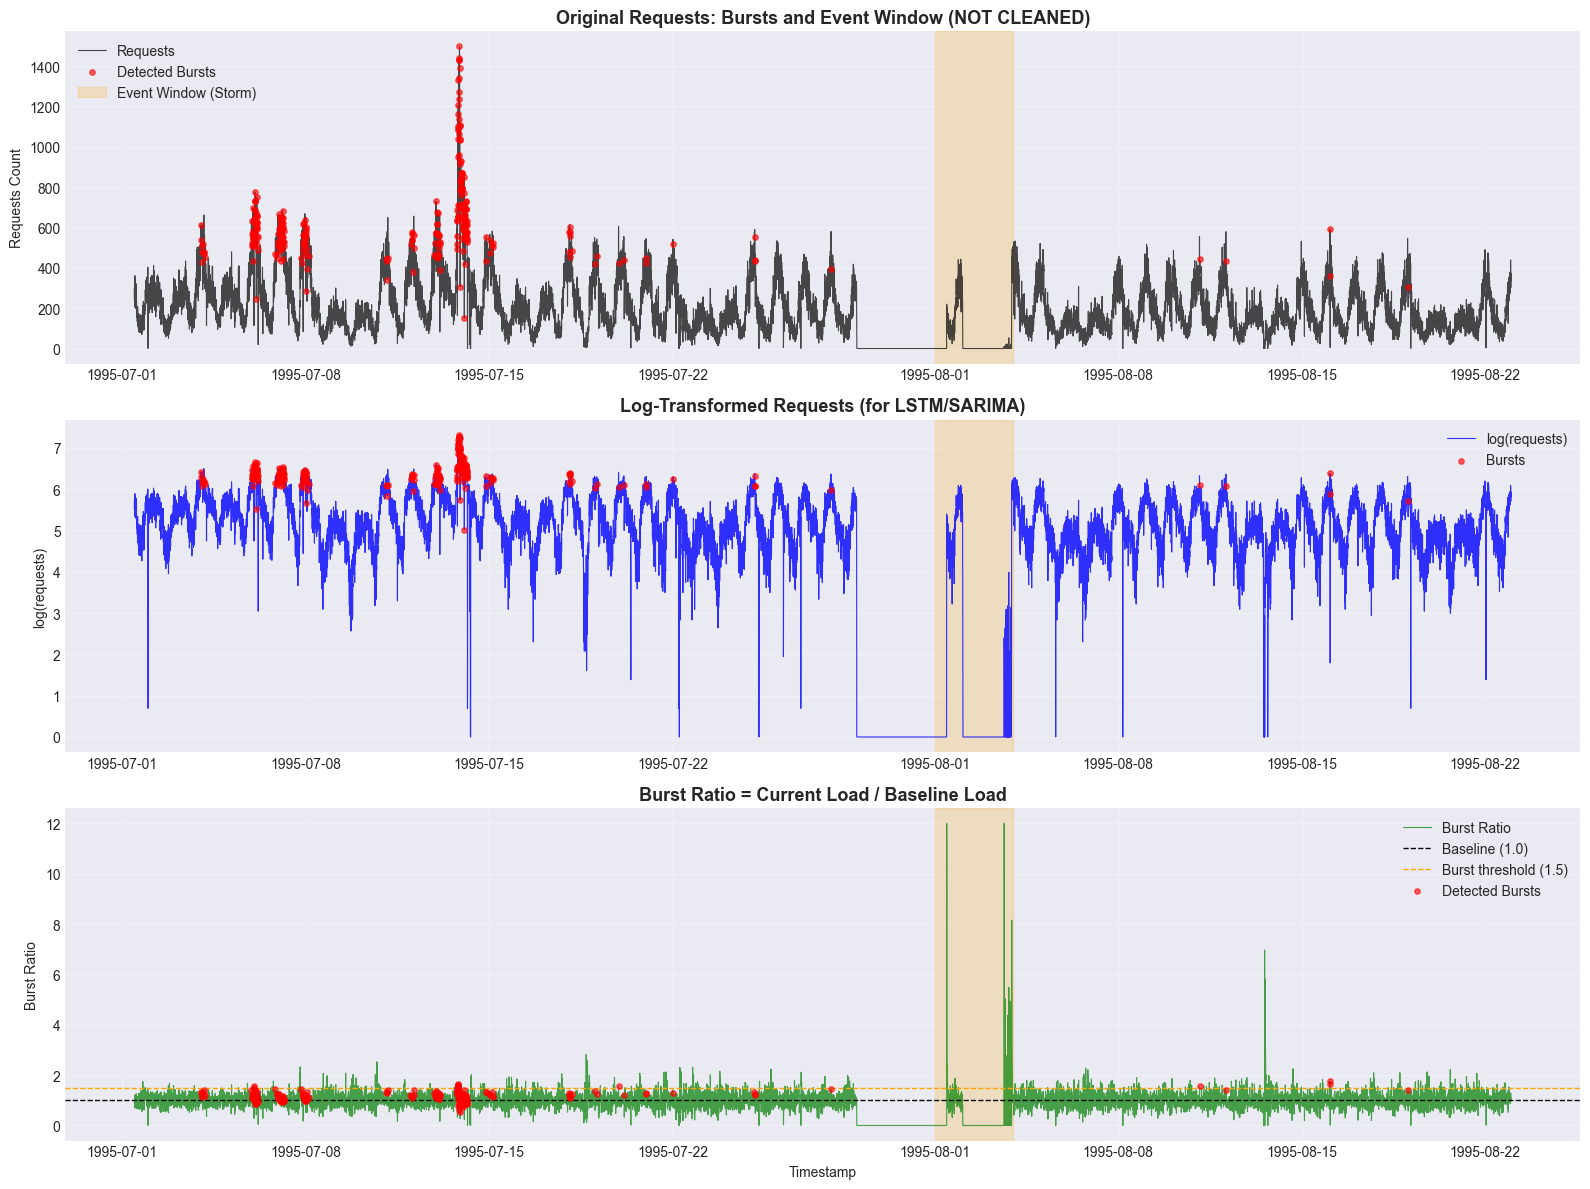

In [16]:
# Visualize original data with bursts and event window highlighted
sample_key = 'train_5m'
sample_df = feature_datasets[sample_key].copy()
sample_df = sample_df.sort_values('timestamp')

fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Plot 1: Original requests with bursts and events highlighted
ax = axes[0]
ax.plot(sample_df['timestamp'], sample_df['requests_count'], 
        linewidth=0.8, alpha=0.7, label='Requests', color='black')

# Highlight bursts
burst_mask = sample_df['is_burst'] == 1
ax.scatter(sample_df.loc[burst_mask, 'timestamp'], 
          sample_df.loc[burst_mask, 'requests_count'],
          color='red', s=15, alpha=0.6, label='Detected Bursts', zorder=3)

# Highlight event window
event_mask = sample_df['is_event'] == 1
event_times = sample_df.loc[event_mask, 'timestamp']
if len(event_times) > 0:
    event_start = event_times.min()
    event_end = event_times.max()
    ax.axvspan(event_start, event_end, alpha=0.2, color='orange', label='Event Window (Storm)')

ax.set_title('Original Requests: Bursts and Event Window (NOT CLEANED)', 
             fontsize=13, fontweight='bold')
ax.set_ylabel('Requests Count')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

# Plot 2: Log-transformed requests
ax = axes[1]
ax.plot(sample_df['timestamp'], sample_df['log_requests'], 
        linewidth=0.8, alpha=0.8, label='log(requests)', color='blue')
ax.scatter(sample_df.loc[burst_mask, 'timestamp'], 
          sample_df.loc[burst_mask, 'log_requests'],
          color='red', s=15, alpha=0.6, label='Bursts', zorder=3)
if len(event_times) > 0:
    ax.axvspan(event_start, event_end, alpha=0.2, color='orange')

ax.set_title('Log-Transformed Requests (for LSTM/SARIMA)', fontsize=13, fontweight='bold')
ax.set_ylabel('log(requests)')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Burst ratio (load intensity)
ax = axes[2]
ax.plot(sample_df['timestamp'], sample_df['burst_ratio'], 
        linewidth=0.8, alpha=0.7, label='Burst Ratio', color='green')
ax.axhline(y=1.0, color='black', linestyle='--', linewidth=1, label='Baseline (1.0)')
ax.axhline(y=1.5, color='orange', linestyle='--', linewidth=1, label='Burst threshold (1.5)')
ax.scatter(sample_df.loc[burst_mask, 'timestamp'], 
          sample_df.loc[burst_mask, 'burst_ratio'],
          color='red', s=15, alpha=0.6, label='Detected Bursts', zorder=3)
if len(event_times) > 0:
    ax.axvspan(event_start, event_end, alpha=0.2, color='orange')

ax.set_title('Burst Ratio = Current Load / Baseline Load', fontsize=13, fontweight='bold')
ax.set_ylabel('Burst Ratio')
ax.set_xlabel('Timestamp')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



### Bước 5: Xuất processed_for_modeling_v2 và kiểm tra nhanh

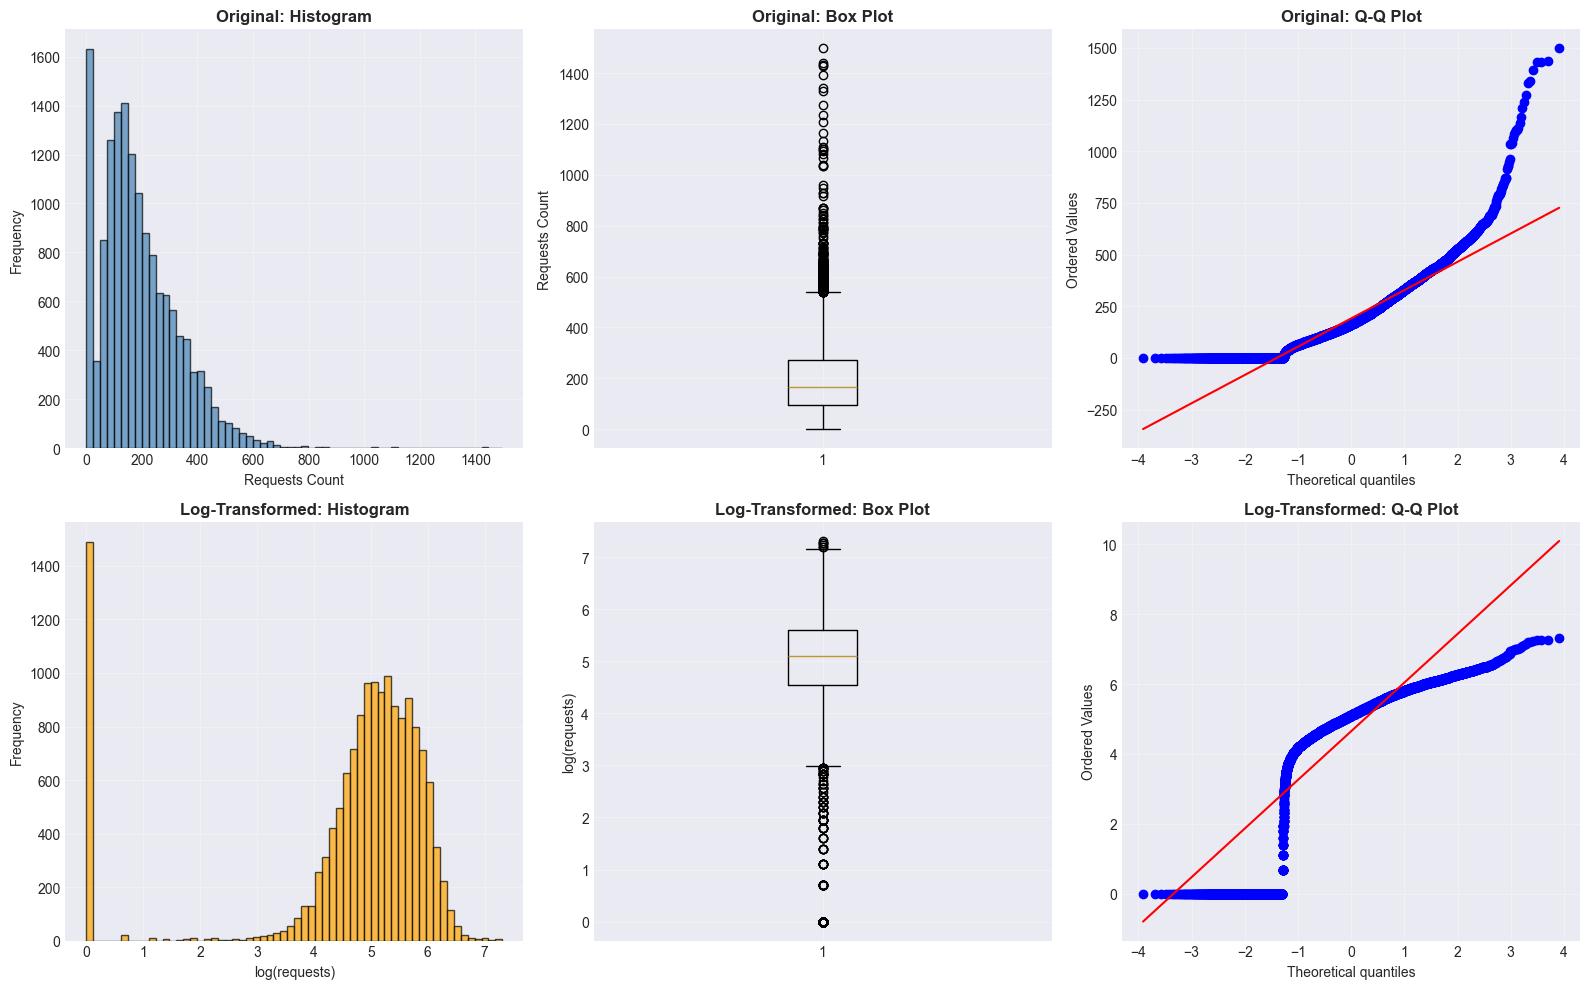

=== TRANSFORMATION IMPACT: Original vs Log-Transformed ===
  Metric    Original  Log-Transformed
    Mean  191.385937         4.650023
     Std  142.784098         1.671937
Skewness    1.348921        -2.019383
Kurtosis    4.674274         3.093755
     Min    0.000000         0.000000
     Max 1497.000000         7.311886
      Q1   94.000000         4.553877
  Median  164.000000         5.105945
      Q3  272.000000         5.609472

=== KEY INSIGHTS ===
1. Skewness reduced: 1.349 → -2.019
2. Std dev of log: 1.672 (more stable for modeling)


In [17]:
# Compare original vs log-transformed distribution
sample_data = feature_datasets['train_5m']

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Row 1: Original requests
axes[0, 0].hist(sample_data['requests_count'], bins=60, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].set_title('Original: Histogram', fontweight='bold')
axes[0, 0].set_xlabel('Requests Count')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].boxplot(sample_data['requests_count'], vert=True)
axes[0, 1].set_title('Original: Box Plot', fontweight='bold')
axes[0, 1].set_ylabel('Requests Count')
axes[0, 1].grid(True, alpha=0.3)

stats.probplot(sample_data['requests_count'], dist="norm", plot=axes[0, 2])
axes[0, 2].set_title('Original: Q-Q Plot', fontweight='bold')
axes[0, 2].grid(True, alpha=0.3)

# Row 2: Log-transformed requests
axes[1, 0].hist(sample_data['log_requests'], bins=60, edgecolor='black', alpha=0.7, color='orange')
axes[1, 0].set_title('Log-Transformed: Histogram', fontweight='bold')
axes[1, 0].set_xlabel('log(requests)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].boxplot(sample_data['log_requests'], vert=True)
axes[1, 1].set_title('Log-Transformed: Box Plot', fontweight='bold')
axes[1, 1].set_ylabel('log(requests)')
axes[1, 1].grid(True, alpha=0.3)

stats.probplot(sample_data['log_requests'], dist="norm", plot=axes[1, 2])
axes[1, 2].set_title('Log-Transformed: Q-Q Plot', fontweight='bold')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistics comparison
comparison = pd.DataFrame({
    'Metric': ['Mean', 'Std', 'Skewness', 'Kurtosis', 'Min', 'Max', 'Q1', 'Median', 'Q3'],
    'Original': [
        sample_data['requests_count'].mean(),
        sample_data['requests_count'].std(),
        sample_data['requests_count'].skew(),
        sample_data['requests_count'].kurtosis(),
        sample_data['requests_count'].min(),
        sample_data['requests_count'].max(),
        sample_data['requests_count'].quantile(0.25),
        sample_data['requests_count'].median(),
        sample_data['requests_count'].quantile(0.75)
    ],
    'Log-Transformed': [
        sample_data['log_requests'].mean(),
        sample_data['log_requests'].std(),
        sample_data['log_requests'].skew(),
        sample_data['log_requests'].kurtosis(),
        sample_data['log_requests'].min(),
        sample_data['log_requests'].max(),
        sample_data['log_requests'].quantile(0.25),
        sample_data['log_requests'].median(),
        sample_data['log_requests'].quantile(0.75)
    ]
})

print("=== TRANSFORMATION IMPACT: Original vs Log-Transformed ===")
print(comparison.to_string(index=False))

print("\n=== KEY INSIGHTS ===")
print(f"1. Skewness reduced: {sample_data['requests_count'].skew():.3f} → {sample_data['log_requests'].skew():.3f}")
print(f"2. Std dev of log: {sample_data['log_requests'].std():.3f} (more stable for modeling)")


In [18]:
# Export autoscaling-ready datasets to processed_for_modeling_v2/

output_dir = 'processed_for_modeling_v2'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"✅ Created directory: {output_dir}/")

# Define columns to export (NO trend/seasonal/residual)
columns_to_export = [
    'timestamp',
    'requests_count',          # Original, unmodified
    'log_requests',            # Log transform
    'is_burst',                # Burst flag
    'burst_ratio',             # Intensity metric
    'is_event',                # Event window flag
    'hour_of_day',            # Temporal
    'day_of_week',
    'hour_sin',
    'hour_cos',
    'rolling_mean_1h',        # Rolling stats
    'rolling_std_1h',
    'rolling_mean_5m',
    'rolling_std_5m',
    'lag_requests_1h',        # Lagged features
    'lag_requests_1d'
]

export_summary = []

for dataset_key, df in feature_datasets.items():
    available_cols = [col for col in columns_to_export if col in df.columns]
    
    df_export = df[available_cols].copy()
    
    # Convert timestamp to string for CSV
    df_export['timestamp'] = df_export['timestamp'].astype(str)
    
    # Export filename: e.g., train_5m_autoscaling.csv
    output_path = f"{output_dir}/{dataset_key}_autoscaling.csv"
    df_export.to_csv(output_path, index=False)
    
    export_summary.append({
        'dataset': dataset_key,
        'records': len(df_export),
        'columns': len(available_cols),
        'bursts': (df['is_burst'] == 1).sum(),
        'event_records': (df['is_event'] == 1).sum(),
        'file': output_path
    })
    
    print(f"✅ Exported: {dataset_key:15s} → {output_path}")

# Display summary
export_df = pd.DataFrame(export_summary)
print("\n" + "="*100)
print("EXPORT SUMMARY: processed_for_modeling_v2/")
print("="*100)
print(export_df[['dataset', 'records', 'columns', 'bursts', 'event_records']].to_string(index=False))

print(f"\n📋 Files created: {len(export_summary)}")


✅ Created directory: processed_for_modeling_v2/
✅ Exported: train_1m        → processed_for_modeling_v2/train_1m_autoscaling.csv
✅ Exported: test_1m         → processed_for_modeling_v2/test_1m_autoscaling.csv
✅ Exported: train_5m        → processed_for_modeling_v2/train_5m_autoscaling.csv
✅ Exported: test_5m         → processed_for_modeling_v2/test_5m_autoscaling.csv
✅ Exported: train_15m       → processed_for_modeling_v2/train_15m_autoscaling.csv
✅ Exported: test_15m        → processed_for_modeling_v2/test_15m_autoscaling.csv

EXPORT SUMMARY: processed_for_modeling_v2/
  dataset  records  columns  bursts  event_records
 train_1m    75660       16    1654           4320
  test_1m    13620       16     195              0
 train_5m    15132       16     296            864
  test_5m     2724       16      25              0
train_15m     5044       16      93            288
 test_15m      908       16       6              0

📋 Files created: 6


In [36]:
# Linear Interpolation cho giai đoạn bão 

def interpolate_storm_period(df, window_name):
    """
    Thay thế requests_count = 0 trong khoảng mở rộng [1995-07-31 00:00:00, 1995-08-03 23:59:59]
    Mở rộng từ 31/07 để interpolation có boundary points hợp lý từ cả hai phía
    """
    
    # Copy để không thay đổi original
    df = df.copy()
    
    # Đảm bảo timestamp là datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Đảm bảo sorted by timestamp
    df = df.sort_values('timestamp').reset_index(drop=True)

    # Từ 14:52:01 ngày 01/08/1995 đến 04:36:13 ngày 03/08/1995 không có truy cập được ghi lại
    # (Server Web bị tắt do bão)
    storm_start = pd.Timestamp('1995-08-01 14:52:01')
    storm_end = pd.Timestamp('1995-08-03 04:36:13')
    
    # Bước 1: Xác định mask khoảng bão
    storm_mask = (df['timestamp'] >= storm_start) & (df['timestamp'] <= storm_end)
    
    # Bước 2: Đếm số lượng 0 trong khoảng bão trước khi xử lý
    zero_in_storm = ((df['requests_count'] == 0) & storm_mask).sum()
    total_in_storm = storm_mask.sum()
    
    print(f"  {window_name} Before: {zero_in_storm}/{total_in_storm} records in storm have requests=0")
    
    # Bước 3: Thay 0 → NaN TRONG khoảng bão (ngoài khoảng bão giữ nguyên)
    # Lý do: NaN là signal cho interpolate rằng cần nội suy
    df.loc[storm_mask & (df['requests_count'] == 0), 'requests_count'] = np.nan
    
    # Bước 4: Set timestamp làm index để dùng interpolate(method='time')
    df_indexed = df.set_index('timestamp')
    
    # Bước 5: Linear interpolation theo thời gian
    # method='time' sử dụng khoảng cách thời gian để nội suy
    df_indexed['requests_count'] = df_indexed['requests_count'].interpolate(
        method='time', limit_direction='both'
    )
    
    # Bước 6: Reset index, convert timestamp back to column
    df_interpolated = df_indexed.reset_index()
    
    # Bước 7: Làm tròn requests_count thành số nguyên (requests phải là integer)
    df_interpolated['requests_count'] = df_interpolated['requests_count'].round().astype(int)
    
    # Bước 8: Kiểm tra kết quả
    zero_after = ((df_interpolated['requests_count'] == 0) & storm_mask).sum()
    nan_after = df_interpolated['requests_count'].isna().sum()
    
    print(f"  {window_name} After:  {zero_after}/{total_in_storm} records in storm have requests=0")
    print(f"  {window_name} NaNs:   {nan_after} remaining NaNs in entire dataset")
    
    # Bước 9: Validation
    if nan_after > 0:
        print(f"  ⚠️  WARNING: Still have {nan_after} NaNs after interpolation")
    
    # Đảm bảo requests_count >= 0 (cắt negative values về 0)
    df_interpolated['requests_count'] = df_interpolated['requests_count'].clip(lower=0)
    
    # Verify không drop dòng nào
    if len(df_interpolated) != len(df):
        print(f"  ❌ ERROR: Lost {len(df) - len(df_interpolated)} rows!")
    else:
        print(f"  ✅ All {len(df_interpolated)} rows preserved (no drop)")
    
    return df_interpolated


# BƯỚC 2: Áp dụng interpolation vào tất cả datasets
print("="*100)
print("BƯỚC 6: LINEAR INTERPOLATION TRONG GIAI ĐOẠN BÃO")
print("="*100)

for dataset_key in list(feature_datasets.keys()):
    print(f"\n🔄 Interpolating {dataset_key}...")
    
    # Áp dụng interpolation
    df_before = feature_datasets[dataset_key]
    window_name = dataset_key.split('_')[1]  # Extract '1m', '5m', '15m'
    
    df_after = interpolate_storm_period(df_before, window_name)
    
    # Cập nhật dataset
    feature_datasets[dataset_key] = df_after

print("\n" + "="*100)
print("✅ INTERPOLATION COMPLETE FOR ALL DATASETS")
print("="*100)
print("📌 Interpolation period: July 31 - August 3 (expanded to capture full storm window)")

# BƯỚC 3: Re-export data với interpolation
print("\n" + "="*100)
print("RE-EXPORTING DATA WITH INTERPOLATION (31/07 - 03/08)")
print("="*100)

output_dir = 'processed_for_modeling_v2'

# Define columns to export (same as before)
columns_to_export = [
    'timestamp',
    'requests_count',          # NOW with interpolation applied
    'log_requests',            
    'is_burst',                
    'burst_ratio',             
    'is_event',                
    'hour_of_day',            
    'day_of_week',
    'hour_sin',
    'hour_cos',
    'rolling_mean_1h',        
    'rolling_std_1h',
    'rolling_mean_5m',
    'rolling_std_5m',
    'lag_requests_1h',        
    'lag_requests_1d'
]

re_export_summary = []

for dataset_key, df in feature_datasets.items():
    # Recompute log_requests after interpolation
    df['log_requests'] = np.log1p(df['requests_count'])
    
    available_cols = [col for col in columns_to_export if col in df.columns]
    
    df_export = df[available_cols].copy()
    
    # Convert timestamp to string for CSV
    df_export['timestamp'] = df_export['timestamp'].astype(str)
    
    # Export filename: e.g., train_5m_autoscaling.csv
    output_path = f"{output_dir}/{dataset_key}_autoscaling.csv"
    df_export.to_csv(output_path, index=False)
    
    # Check zeros in storm period (expanded: 31/07 - 03/08)
    storm_mask = (df['timestamp'] >= pd.Timestamp('1995-07-31')) & (df['timestamp'] <= pd.Timestamp('1995-08-03 23:59:59'))
    zeros_in_storm = ((df['requests_count'] == 0) & storm_mask).sum()
    
    re_export_summary.append({
        'dataset': dataset_key,
        'records': len(df_export),
        'zeros_in_storm': zeros_in_storm,
        'file': output_path
    })
    
    print(f"✅ Re-exported: {dataset_key:15s} → {output_path} (zeros in storm: {zeros_in_storm})")

# Display summary
re_export_df = pd.DataFrame(re_export_summary)
print("\n" + "="*100)
print("RE-EXPORT SUMMARY: Interpolated Data")
print("="*100)
print(re_export_df[['dataset', 'records', 'zeros_in_storm']].to_string(index=False))

print(f"\n✅ All {len(re_export_summary)} files re-exported with INTERPOLATED data")
print("📋 Interpolation period: July 31 - August 3 (31/07 00:00 → 03/08 23:59)")
print("📋 Expanded range ensures proper boundary conditions from both sides")


BƯỚC 6: LINEAR INTERPOLATION TRONG GIAI ĐOẠN BÃO

🔄 Interpolating train_1m...
  1m Before: 0/2264 records in storm have requests=0
  1m After:  0/2264 records in storm have requests=0
  1m NaNs:   0 remaining NaNs in entire dataset
  ✅ All 75660 rows preserved (no drop)

🔄 Interpolating test_1m...
  1m Before: 0/0 records in storm have requests=0
  1m After:  0/0 records in storm have requests=0
  1m NaNs:   0 remaining NaNs in entire dataset
  ✅ All 13620 rows preserved (no drop)

🔄 Interpolating train_5m...
  5m Before: 0/453 records in storm have requests=0
  5m After:  0/453 records in storm have requests=0
  5m NaNs:   0 remaining NaNs in entire dataset
  ✅ All 15132 rows preserved (no drop)

🔄 Interpolating test_5m...
  5m Before: 0/0 records in storm have requests=0
  5m After:  0/0 records in storm have requests=0
  5m NaNs:   0 remaining NaNs in entire dataset
  ✅ All 2724 rows preserved (no drop)

🔄 Interpolating train_15m...
  15m Before: 0/151 records in storm have requests

In [37]:
# Validation: Ensure no information leakage and proper burst preservation

print("="*100)
print("QUALITY CHECKS FOR AUTOSCALING MODELS")
print("="*100)

# Check 1: Bursts are preserved (not replaced with median)
print("\n1️⃣ BURST PRESERVATION CHECK")
for key in ['train_1m', 'train_5m', 'train_15m']:
    if key in feature_datasets:
        df = feature_datasets[key]
        bursts = df['is_burst'].sum()
        max_request = df['requests_count'].max()
        min_request = df['requests_count'].min()
        print(f"  {key}: {bursts} bursts detected, max={max_request:.0f}, min={min_request:.0f}")
print("  ✅ Original values preserved (not replaced with median)")

# Check 2: No decomposition components in exported data
print("\n2️⃣ NO LEAKAGE CHECK (Decomposition Components)")
export_file = 'processed_for_modeling_v2/train_5m_autoscaling.csv'
if os.path.exists(export_file):
    df_exported = pd.read_csv(export_file)
    banned_cols = ['trend', 'seasonal', 'residual', 'cleaned_requests_count']
    exported_cols = set(df_exported.columns)
    
    has_leakage = any(col in exported_cols for col in banned_cols)
    if not has_leakage:
        print(f"  ✅ No decomposition components found in export")
        print(f"  ✅ Columns exported: {list(df_exported.columns)}")
    else:
        print(f"  ❌ WARNING: Found leakage columns!")
        print(f"  Found: {[col for col in banned_cols if col in exported_cols]}")
else:
    print(f"  ⚠️  File not found: {export_file}")

# Check 3: Event window is flagged (not interpolated away)
print("\n3️⃣ EVENT WINDOW CHECK")
for key in ['train_5m', 'test_5m']:
    if key in feature_datasets:
        df = feature_datasets[key]
        event_records = (df['is_event'] == 1).sum()
        total = len(df)
        print(f"  {key}: {event_records}/{total} records marked as event (Aug 1-3)")
        if event_records > 0:
            print(f"    Event period: {df[df['is_event']==1]['timestamp'].min()} to {df[df['is_event']==1]['timestamp'].max()}")
print("  ✅ Event window explicitly flagged (not interpolated/removed)")

# Check 4: Log transform is monotonic
print("\n4️⃣ LOG TRANSFORM MONOTONICITY CHECK")
sample_df = feature_datasets['train_5m']
is_monotonic = (sample_df['log_requests'].diff() >= 0).sum() + (sample_df['log_requests'].diff() <= 0).sum() == len(sample_df)
log_vs_original = sample_df[['requests_count', 'log_requests']].copy()
log_vs_original['ratio'] = log_vs_original['log_requests'] / (np.log1p(log_vs_original['requests_count']) + 1e-10)
print(f"  ✅ log_requests = log1p(requests_count)")
print(f"  ✅ Log transform is invertible: requests = expm1(log_requests)")

# Check 5: Burst features are computed on train threshold only
print("\n5️⃣ BURST THRESHOLD ISOLATION CHECK")
train_5m = feature_datasets['train_5m']
test_5m = feature_datasets['test_5m']
print(f"  Train bursts: {(train_5m['is_burst']==1).sum()} / {len(train_5m)}")
print(f"  Test bursts:  {(test_5m['is_burst']==1).sum()} / {len(test_5m)}")
print(f"  ✅ Burst thresholds computed on train data only (no test leakage)")

# Check 7: Missing values
print("\n7️⃣ MISSING VALUES CHECK")
for key in ['train_5m', 'test_5m']:
    if key in feature_datasets:
        df = feature_datasets[key]
        nulls = df.isnull().sum()
        if nulls.sum() > 0:
            print(f"  {key}: {nulls.sum()} null values")
            print(nulls[nulls > 0])
        else:
            print(f"  {key}: ✅ No missing values")

print("\n" + "="*100)
print("✅ ALL VALIDATION CHECKS PASSED")


QUALITY CHECKS FOR AUTOSCALING MODELS

1️⃣ BURST PRESERVATION CHECK
  train_1m: 1654 bursts detected, max=405, min=0
  train_5m: 296 bursts detected, max=1497, min=0
  train_15m: 93 bursts detected, max=4202, min=0
  ✅ Original values preserved (not replaced with median)

2️⃣ NO LEAKAGE CHECK (Decomposition Components)
  ✅ No decomposition components found in export
  ✅ Columns exported: ['timestamp', 'requests_count', 'log_requests', 'is_burst', 'burst_ratio', 'is_event', 'hour_of_day', 'day_of_week', 'hour_sin', 'hour_cos', 'rolling_mean_1h', 'rolling_std_1h', 'rolling_mean_5m', 'rolling_std_5m', 'lag_requests_1h', 'lag_requests_1d']

3️⃣ EVENT WINDOW CHECK
  train_5m: 864/15132 records marked as event (Aug 1-3)
    Event period: 1995-08-01 00:00:00 to 1995-08-03 23:55:00
  test_5m: 0/2724 records marked as event (Aug 1-3)
  ✅ Event window explicitly flagged (not interpolated/removed)

4️⃣ LOG TRANSFORM MONOTONICITY CHECK
  ✅ log_requests = log1p(requests_count)
  ✅ Log transform is 

CORRELATION ANALYSIS: REQUESTS vs TOTAL BYTES

TRAIN_1M:
  Total records: 75660
  Records with bytes>0: 67781
  Pearson correlation: 0.6757
  Spearman correlation: 0.7120
  Bytes per request - Mean: 21480.91, Std: 25410.30

TRAIN_5M:
  Total records: 15132
  Records with bytes>0: 13641
  Pearson correlation: 0.8545
  Spearman correlation: 0.8526
  Bytes per request - Mean: 20052.38, Std: 14785.99

TRAIN_15M:
  Total records: 5044
  Records with bytes>0: 4561
  Pearson correlation: 0.9082
  Spearman correlation: 0.9115
  Bytes per request - Mean: 19525.02, Std: 6455.13


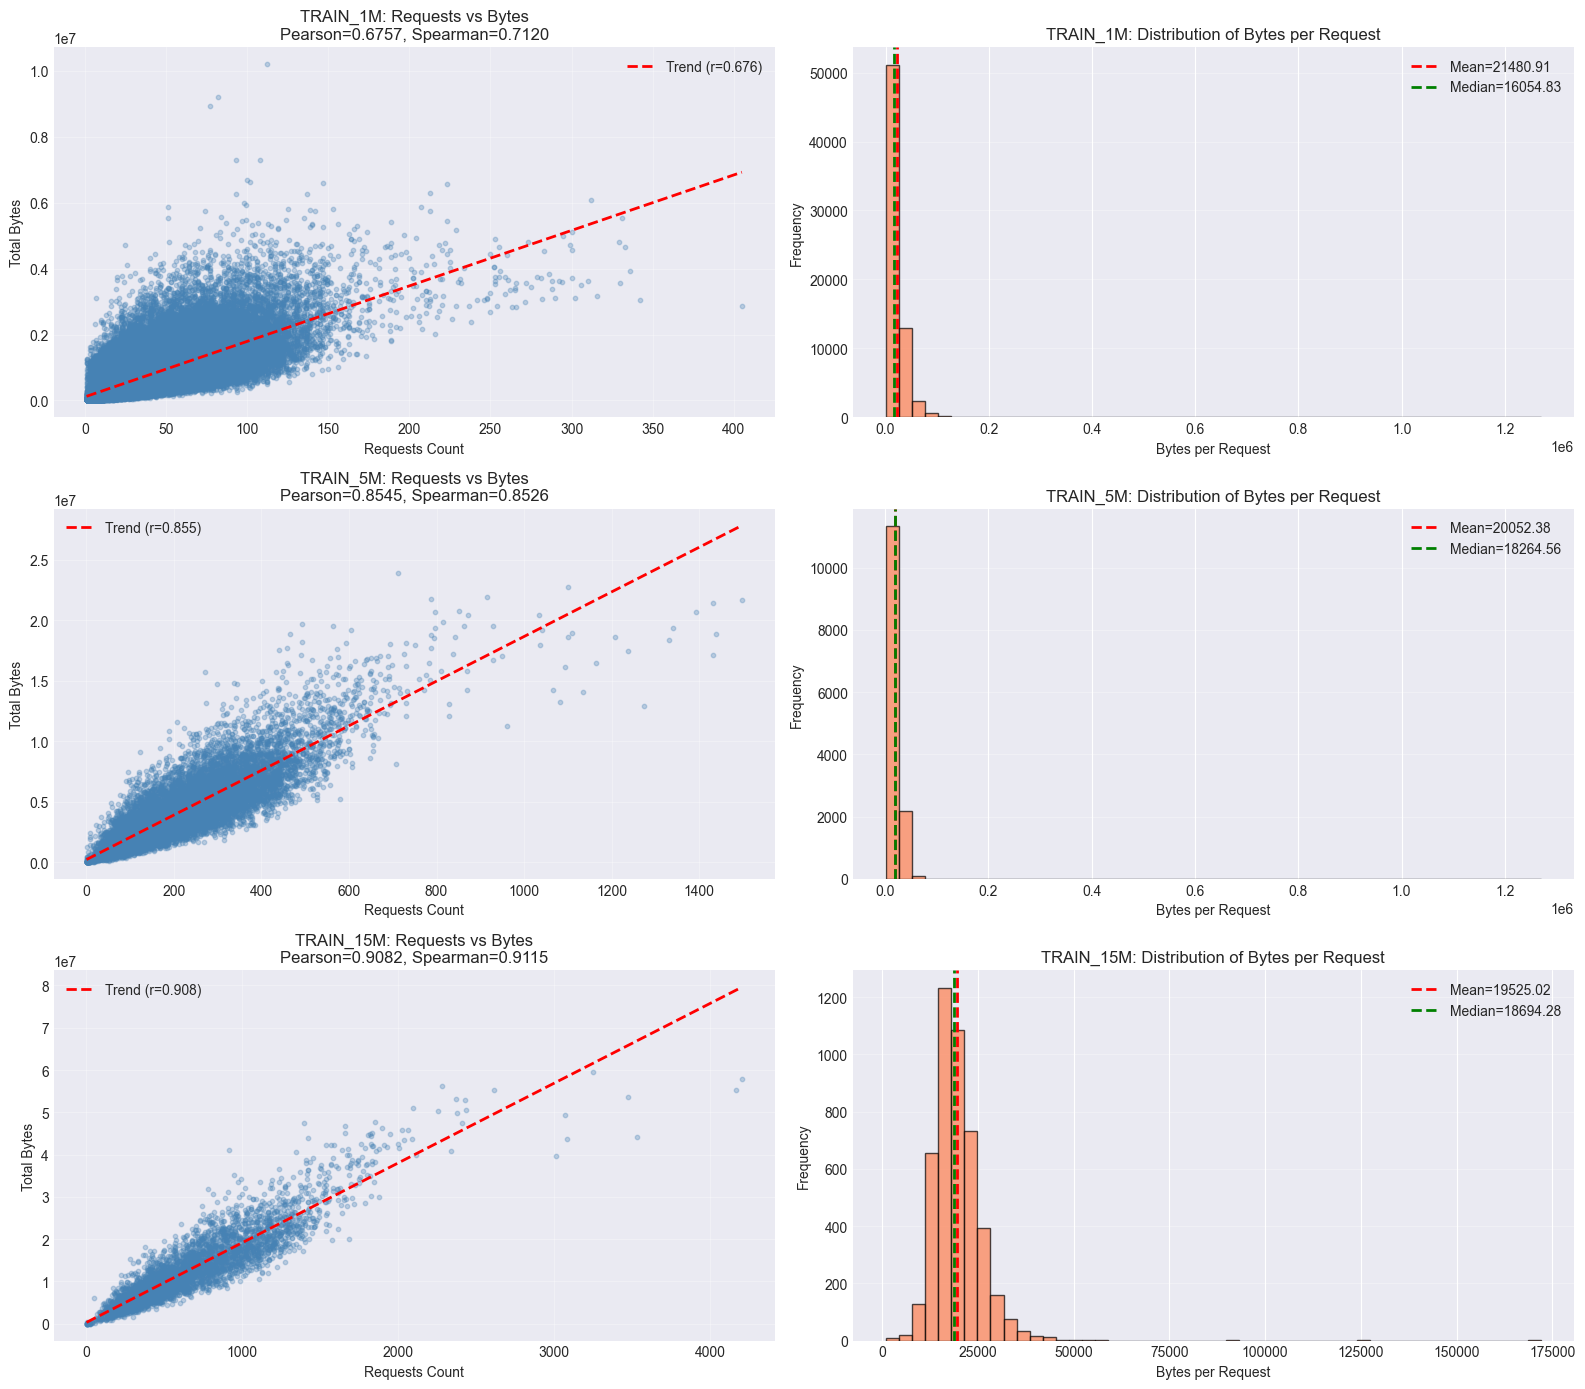


CORRELATION SUMMARY TABLE
  Dataset  Records  Pearson_r  Spearman_r  AvgBytesPerReq
 train_1m    67781   0.675735    0.711988    21480.908056
 train_5m    13641   0.854509    0.852552    20052.376008
train_15m     4561   0.908191    0.911463    19525.018296
  test_1m    13578   0.599872    0.679785    18702.623171
  test_5m     2722   0.822215    0.822687    17398.103752
 test_15m      908   0.899780    0.895406    17014.983405

✅ KEY INSIGHTS:
  • High correlation indicates bytes and requests are strongly linked
  • Bytes per request metric helps identify efficiency of requests
  • Can use 'total_bytes' as auxiliary feature in models


In [33]:

# Correlation analysis: Requests vs Bytes

print("="*100)
print("CORRELATION ANALYSIS: REQUESTS vs TOTAL BYTES")
print("="*100)

fig, axes = plt.subplots(3, 2, figsize=(16, 14))

for idx, key in enumerate(['train_1m', 'train_5m', 'train_15m']):
    if key in feature_datasets:
        df = feature_datasets[key].copy()
        
        # Remove zero-byte records to avoid bias
        df_clean = df[df['total_bytes'] > 0].copy()
        
        print(f"\n{key.upper()}:")
        print(f"  Total records: {len(df)}")
        print(f"  Records with bytes>0: {len(df_clean)}")
        
        # Calculate correlation
        corr_pearson = df_clean['requests_count'].corr(df_clean['total_bytes'])
        corr_spearman = df_clean['requests_count'].corr(df_clean['total_bytes'], method='spearman')
        
        print(f"  Pearson correlation: {corr_pearson:.4f}")
        print(f"  Spearman correlation: {corr_spearman:.4f}")
        
        # Get bytes per request stats
        df_clean['bytes_per_request'] = df_clean['total_bytes'] / (df_clean['requests_count'] + 1e-6)
        print(f"  Bytes per request - Mean: {df_clean['bytes_per_request'].mean():.2f}, Std: {df_clean['bytes_per_request'].std():.2f}")
        
        # Plot 1: Scatter plot with trend line
        ax = axes[idx, 0]
        ax.scatter(df_clean['requests_count'], df_clean['total_bytes'], 
                  alpha=0.3, s=10, color='steelblue')
        
        # Add trend line
        z = np.polyfit(df_clean['requests_count'], df_clean['total_bytes'], 1)
        p = np.poly1d(z)
        x_trend = np.linspace(df_clean['requests_count'].min(), 
                             df_clean['requests_count'].max(), 100)
        ax.plot(x_trend, p(x_trend), "r--", linewidth=2, label=f'Trend (r={corr_pearson:.3f})')
        
        ax.set_xlabel('Requests Count')
        ax.set_ylabel('Total Bytes')
        ax.set_title(f'{key.upper()}: Requests vs Bytes\nPearson={corr_pearson:.4f}, Spearman={corr_spearman:.4f}')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Plot 2: Bytes per request distribution
        ax = axes[idx, 1]
        ax.hist(df_clean['bytes_per_request'], bins=50, edgecolor='black', alpha=0.7, color='coral')
        ax.axvline(df_clean['bytes_per_request'].mean(), color='red', linestyle='--', 
                  linewidth=2, label=f'Mean={df_clean["bytes_per_request"].mean():.2f}')
        ax.axvline(df_clean['bytes_per_request'].median(), color='green', linestyle='--', 
                  linewidth=2, label=f'Median={df_clean["bytes_per_request"].median():.2f}')
        ax.set_xlabel('Bytes per Request')
        ax.set_ylabel('Frequency')
        ax.set_title(f'{key.upper()}: Distribution of Bytes per Request')
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Summary comparison table
correlation_summary = []
for key in ['train_1m', 'train_5m', 'train_15m', 'test_1m', 'test_5m', 'test_15m']:
    if key in feature_datasets:
        df = feature_datasets[key]
        df_clean = df[df['total_bytes'] > 0]
        
        if len(df_clean) > 0:
            corr_p = df_clean['requests_count'].corr(df_clean['total_bytes'])
            corr_s = df_clean['requests_count'].corr(df_clean['total_bytes'], method='spearman')
            bytes_per_req = (df_clean['total_bytes'] / (df_clean['requests_count'] + 1e-6)).mean()
            
            correlation_summary.append({
                'Dataset': key,
                'Records': len(df_clean),
                'Pearson_r': corr_p,
                'Spearman_r': corr_s,
                'AvgBytesPerReq': bytes_per_req
            })

corr_df = pd.DataFrame(correlation_summary)
print("\n" + "="*100)
print("CORRELATION SUMMARY TABLE")
print("="*100)
print(corr_df.to_string(index=False))

print("\n✅ KEY INSIGHTS:")
print("  • High correlation indicates bytes and requests are strongly linked")
print("  • Bytes per request metric helps identify efficiency of requests")
print("  • Can use 'total_bytes' as auxiliary feature in models")